In [17]:
import itertools
import csv
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy import stats

import pingouin as pg
import pandas as pd
import seaborn as sns

# Initialize Study
Change `Modality` to see analysis for each dataset

In [2]:
Model_Mode = 'Periods' #["IC", "Channels", "Periods", "Time"];

Modality = 'EEGfMRI' #'EEGfMRI' 'MMEG'; # EEG2 EEG MEG GMEG GMEG2 GMEG3
# Modality = 'MMEG'

if Modality == 'MMEG':
    
    Subjects_list = list(range(1, 18+1));
    Tasks_list = [4] # [1, 2] # list(range(1, 2 + 1));
    Task_name = {4: 'Auditory'}

elif Modality == 'EEGfMRI':

    Subjects_list = list(range(1, 17+1));
    Tasks_list = [1, 2] # list(range(1, 2 + 1));
    Task_name = {1: 'Auditory', 2: 'Visual'}

else:
    pass

Learn_methods_list = ["transition"] #, "frequency"];
SurpriseMethods_list = ["KL2", "LOG", "PUZ"];
# ['early', 'mmn', 'p300', 'all', 'signal']
Periods_list = ['baseline', 'early', 'middle', 'late',]# 'all', 'signal']

csv_dir = f'csv_reports_{Modality}'
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)
    
surprie_dict = {
    'KL2': 'Bayesian',
    'LOG': 'Shannon',
    'PUZ': 'Confidence-corrected',
}

In [3]:
decoding_powers = {}
for SurpriseMethod in SurpriseMethods_list:
    for Period in Periods_list:
        for learn_method in Learn_methods_list:
            for TaskNumber in Tasks_list:
                r2_subs = []
                for Sub in Subjects_list:
                    # filename = 'Run_Model_EEG2_Periods_Subject01_Task2_transition_KL2_early'
                    filename = f'Run_Model_{Modality}_{Model_Mode}_Subject{Sub:02}_Task{TaskNumber}_{learn_method}_{SurpriseMethod}_{Period}.mat'
                    filepath = os.path.join('..', 'Output', f'{Modality}_{Model_Mode}', filename)
                    # print(filename)
                    data = sio.loadmat(filepath)
                    
                    r_sq = data['data']['Model_Rs'][0, 0]['R_CV'][0, 0]
                    r_sq[np.isnan(r_sq)] = 0
                    r2_subs.append(r_sq)
                
                res = np.asarray(r2_subs).squeeze()
                decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'] = res

In [4]:
datalist = [[Modality] + [f'{item[0]} {item[1]} {item[2]}'
                    for item in itertools.product(Tasks_list, SurpriseMethods_list, Learn_methods_list)]]

for Period in Periods_list:
    data_period = [Period]
    for TaskNumber, SurpriseMethod, learn_method in \
            itertools.product(Tasks_list, SurpriseMethods_list, Learn_methods_list):
        r2 = decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
        # data_period.append(f'{r2[:, 0].mean():.3f} ± {r2[:, 0].std():.3f}')
        # print(r2.max(axis=1))
        data_period.append(
            f'{r2.max(axis=1).mean():.3f} ± {r2.max(axis=1).std():.3f}')

    datalist.append(data_period)
    
with open(os.path.join(csv_dir, f'r2_{Modality}.csv'), "w+") as r2_functional:
    csvWriter = csv.writer(r2_functional, delimiter=',')
    csvWriter.writerows(datalist)

with open(os.path.join(csv_dir, f'r2_{Modality}.csv'), "r") as r2_functional:
    for l in r2_functional.readlines():
        print(l.strip())

EEGfMRI,1 KL2 transition,1 LOG transition,1 PUZ transition,2 KL2 transition,2 LOG transition,2 PUZ transition
baseline,0.003 ± 0.001,0.002 ± 0.001,0.002 ± 0.001,0.002 ± 0.001,0.002 ± 0.001,0.002 ± 0.001
early,0.004 ± 0.006,0.008 ± 0.017,0.013 ± 0.028,0.004 ± 0.010,0.012 ± 0.022,0.010 ± 0.016
middle,0.134 ± 0.072,0.226 ± 0.129,0.172 ± 0.107,0.155 ± 0.080,0.317 ± 0.108,0.215 ± 0.101
late,0.113 ± 0.089,0.194 ± 0.133,0.164 ± 0.110,0.136 ± 0.081,0.237 ± 0.131,0.174 ± 0.100


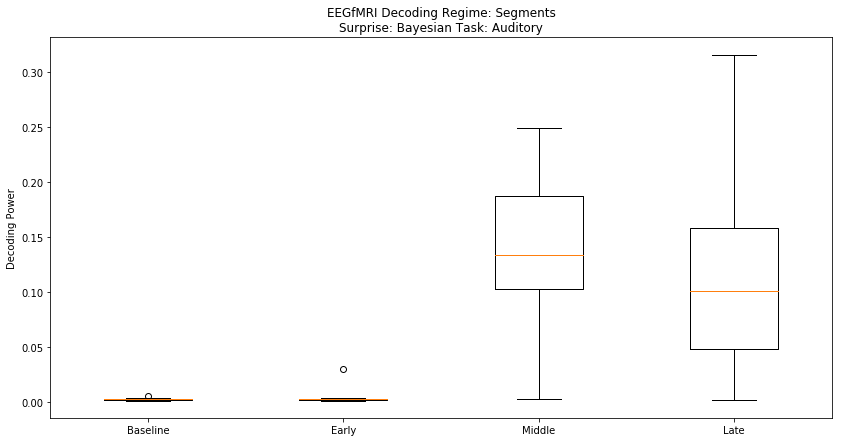

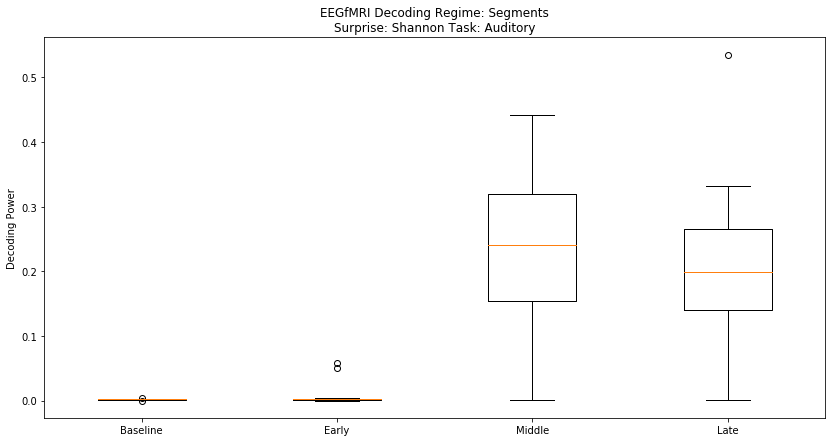

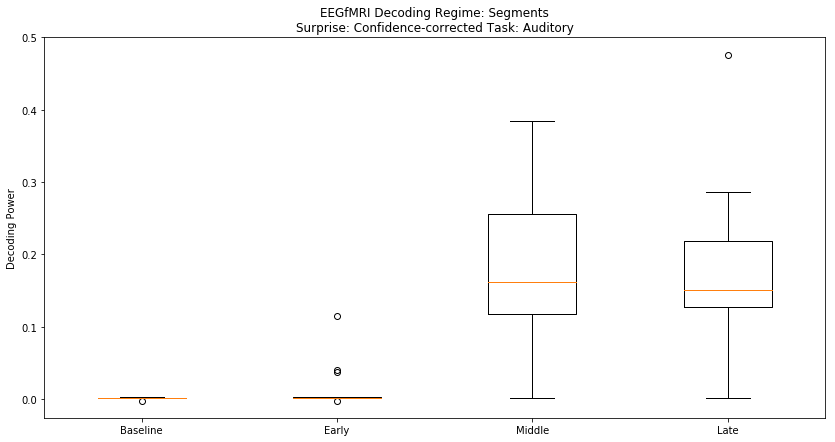

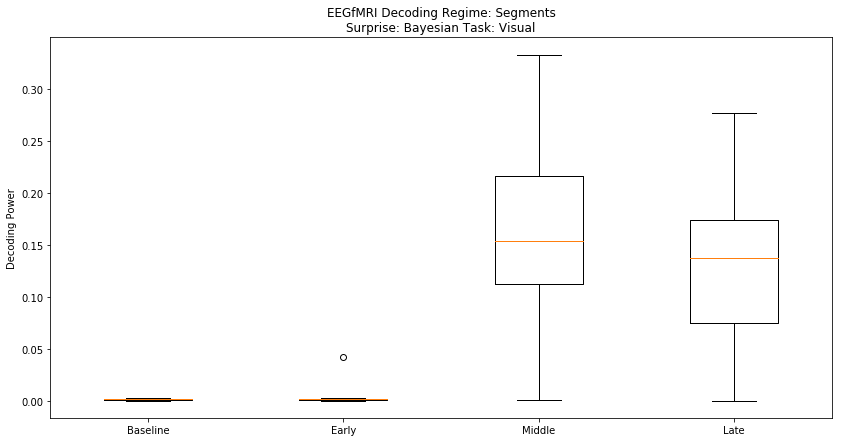

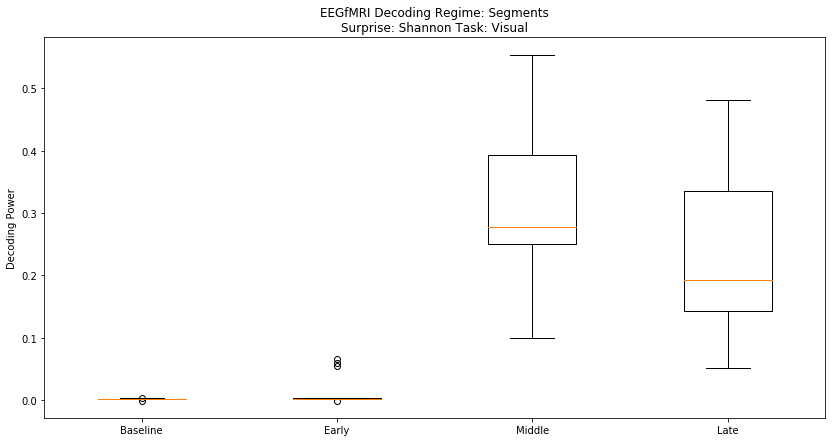

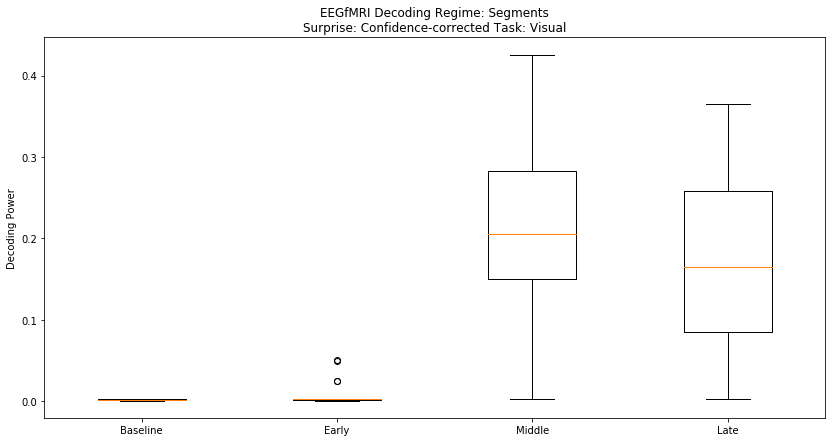

In [5]:
datalist = []

for TaskNumber, SurpriseMethod, learn_method in \
itertools.product(Tasks_list, SurpriseMethods_list, Learn_methods_list):
    
    data_period = []
    
    for Period in Periods_list:
        r2 = decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
        # data_period.append(f'{r2[:, 0].mean():.3f} ± {r2[:, 0].std():.3f}')
        data_period.append(r2.max(axis=1))
    
    fig = plt.figure(figsize=(14, 7))
    plt.boxplot(np.asarray(data_period).T)
    plt.title(f'{Modality} Decoding Regime: Segments\n' + 
              f'Surprise: {surprie_dict[SurpriseMethod]} Task: {Task_name[TaskNumber]}')
    plt.ylabel('Decoding Power')
    plt.xticks(range(1, Periods_list.__len__() + 1), [p.capitalize() for p in Periods_list])
    
    if not os.path.exists(os.path.join('plots', f'r2_periods_{Modality}',)):
                        os.makedirs(os.path.join('plots', f'r2_periods_{Modality}',))
                    
    plt.savefig(os.path.join('plots', f'r2_periods_{Modality}', 
                             f'{Modality}_{SurpriseMethod}_Task{TaskNumber}_{learn_method}'))
    plt.show()
    plt.close(fig)

In [6]:
for Sub in Subjects_list:
    datalist = [[Modality] + [f'{item[0]} {item[1]} {item[2]}'
                        for item in itertools.product(SurpriseMethods_list, Tasks_list, Learn_methods_list)]]

    for Period in Periods_list:
        data_period = [Period]
        for SurpriseMethod, TaskNumber, learn_method in \
                itertools.product(SurpriseMethods_list, Tasks_list, Learn_methods_list):
            r2 = decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
            # data_period.append(r2[Sub, 0])
            data_period.append(r2[Subjects_list.index(Sub), :].max())

        datalist.append(data_period)

    with open(os.path.join(csv_dir, f'r2_{Sub}_{Modality}.csv'), "w+") as r2_functional:
        csvWriter = csv.writer(r2_functional, delimiter=',')
        csvWriter.writerows(datalist)


In [7]:
for TaskNumber, learn_method in itertools.product(Tasks_list, Learn_methods_list):
    datalist = [[Modality] + [f'{sm1}, {sm2}' for sm1,
                        sm2 in itertools.combinations(SurpriseMethods_list, 2)]]

    for Period in Periods_list:
        data_period = [Period]
        for sm1, sm2 in itertools.combinations(SurpriseMethods_list, 2):
            r2_sm1 = decoding_powers[f'{Period}_{sm1}_{TaskNumber}_{learn_method}']
            r2_sm2 = decoding_powers[f'{Period}_{sm2}_{TaskNumber}_{learn_method}']
            # t, p = stats.ttest_ind(r2_sm1[:, 0], r2_sm2[:, 0])
            t, p = stats.ttest_ind(r2_sm1.max(axis=1), r2_sm2.max(axis=1))
            
            data_period.append(p)

        datalist.append(data_period)

    with open(os.path.join(csv_dir, f'pv_period_{Modality}_{TaskNumber}_{learn_method}.csv'), "w+") as pv_period:
        csvWriter = csv.writer(pv_period, delimiter=',')
        csvWriter.writerows(datalist)
        
    with open(os.path.join(csv_dir, f'pv_period_{Modality}_{TaskNumber}_{learn_method}.csv'), "r") as r2_functional:
        for l in r2_functional.readlines():
            print(l.strip())

EEGfMRI,"KL2, LOG","KL2, PUZ","LOG, PUZ"
baseline,0.006183472836768851,0.019505796565951368,0.9072170353430694
early,0.39766310053257137,0.2277537049023466,0.5474306651995358
middle,0.018132852345421592,0.24626569940250215,0.20916826034574076
late,0.05031523443128984,0.16068653066376185,0.484527043342062
EEGfMRI,"KL2, LOG","KL2, PUZ","LOG, PUZ"
baseline,0.27117609082860583,0.7879964389009015,0.3797338386462329
early,0.22082116790673123,0.21466014572009598,0.8143090258105516
middle,3.4898231195260355e-05,0.07600743812072783,0.009210032731420723
late,0.012591107168066572,0.2416735003232042,0.13290406493899293


In [8]:
for TaskNumber, learn_method in itertools.product(Tasks_list, Learn_methods_list):
    datalist = [[Modality] + [f'{p1}, {p2}' for p1,
                        p2 in itertools.combinations(Periods_list, 2)]]

    for SurpriseMethod in SurpriseMethods_list:
        data_period = [SurpriseMethod]
        for p1, p2 in itertools.combinations(Periods_list, 2):
            r2_p1 = decoding_powers[f'{p1}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
            r2_p2 = decoding_powers[f'{p2}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
            # t, p = stats.ttest_ind(r2_p1[:, 0], r2_p2[:, 0])
            t, p = stats.ttest_ind(r2_p1.max(axis=1), r2_p2.max(axis=1))
            data_period.append(p)

        datalist.append(data_period)

    with open(os.path.join(csv_dir, f'pv_surprise_{Modality}_{TaskNumber}_{learn_method}.csv'), "w+") as pv_period:
        csvWriter = csv.writer(pv_period, delimiter=',')
        csvWriter.writerows(datalist)
        
    with open(os.path.join(csv_dir, f'pv_surprise_{Modality}_{TaskNumber}_{learn_method}.csv'), "r") as r2_functional:
        for l in r2_functional.readlines():
            print(l.strip())


EEGfMRI,"baseline, early","baseline, middle","baseline, late","early, middle","early, late","middle, late"
KL2,0.37740128381389404,2.6518902938195734e-08,2.3174806538773087e-05,3.584739980771697e-08,2.8969607702577665e-05,0.4685638918681546
LOG,0.1591019353134381,7.397796206254429e-08,1.9721979909693602e-06,1.489927385833743e-07,3.844251438215971e-06,0.49849323993594885
PUZ,0.12569734453519957,4.179633430528772e-07,1.5203554055707719e-06,2.4119033498360117e-06,8.088503943477144e-06,0.8295117447326521
EEGfMRI,"baseline, early","baseline, middle","baseline, late","early, middle","early, late","middle, late"
KL2,0.3355642837302806,1.0658038792094277e-08,1.9744535432461322e-07,1.7068523599425042e-08,3.13528897630679e-07,0.4922510469150768
LOG,0.075442187552688,4.53148263576238e-13,3.4367283702044465e-08,1.816830597585528e-12,1.0962243576643553e-07,0.06783395939223766
PUZ,0.046237777503160896,1.3212011927020956e-09,8.080329088552513e-08,4.204076066069516e-09,2.677512789414756e-07,0.25897520

/usr/local/share/.virtualenvs/sci/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/share/.virtualenvs/sci/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


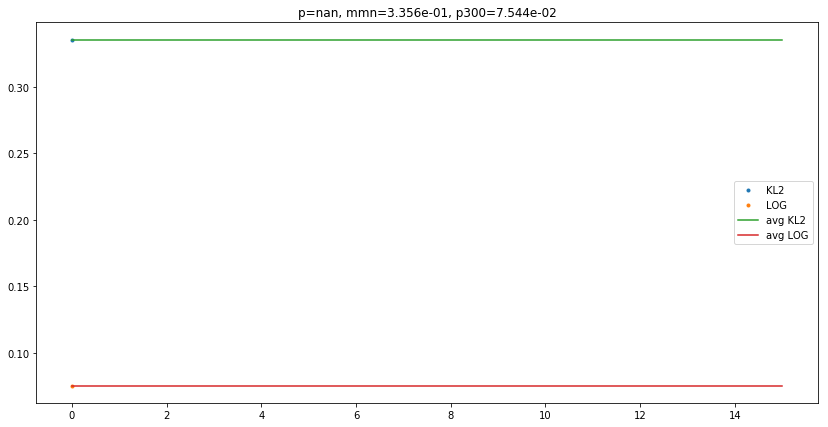

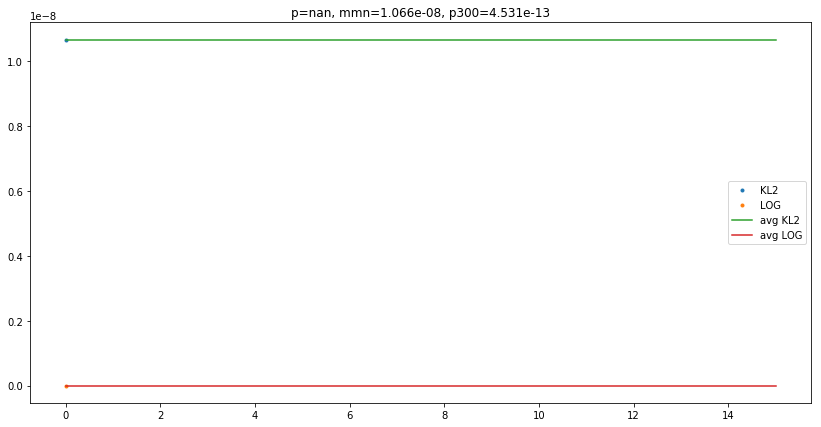

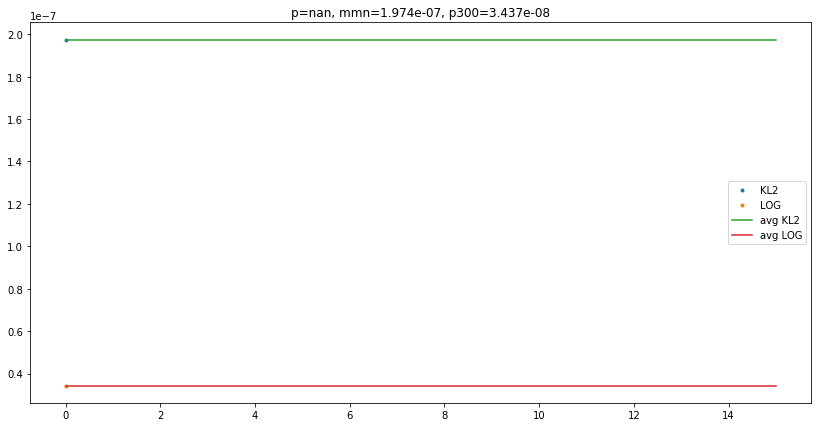

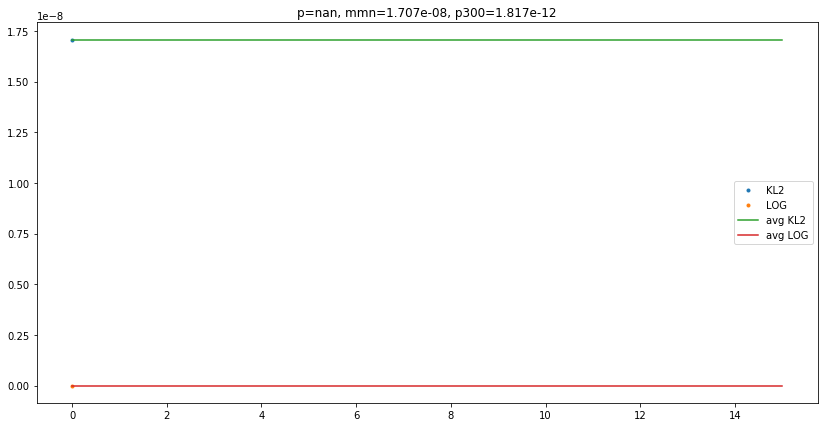

In [9]:
for i in range(1, 5):
    plt.figure(figsize=(14, 7))
    t, p = stats.ttest_ind(datalist[1][i], datalist[2][i])
    plt.plot(datalist[1][i], '.', label=datalist[1][0])
    plt.plot(datalist[2][i], '.', label=datalist[2][0])
    plt.plot(datalist[1][i].mean() * np.ones((16,)), label=f'avg {datalist[1][0]}')
    plt.plot(datalist[2][i].mean() * np.ones((16,)), label=f'avg {datalist[2][0]}')
    plt.title(f'p={p:.3e}, mmn={datalist[1][i].mean():.3e}, p300={datalist[2][i].mean():.3e}')
    plt.legend()
    plt.show()

In [10]:
null_decoding_powers = {}
for SurpriseMethod in SurpriseMethods_list:
    for Period in Periods_list:
        for learn_method in Learn_methods_list:
            for TaskNumber in Tasks_list:
                r2_subs = []
                for Sub in Subjects_list:
                    filename = f'Run_Model_{Modality}_{Model_Mode}_Subject{Sub:02}_Task{TaskNumber}_{learn_method}_{SurpriseMethod}_{Period}.mat'
                    filepath = os.path.join('..', 'Output', f'{Modality}_{Model_Mode}', filename)
                    # print(filename)
                    data = sio.loadmat(filepath)
                    r_sq = np.asarray(data['data'][0, 0]['Model_Rs']['R_CV'].tolist()).squeeze()
                    # r_sq = data['Meyniel_Rs']['R_CV'][0, 0]
                    r_sq[np.isnan(r_sq)] = 0
                    r2_subs.append(r_sq)
                
                res = np.asarray(r2_subs).squeeze()
                null_decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'] = res

In [11]:
datalist = [[Modality] + [f'{item[0]} {item[1]} {item[2]}'
                   for item in itertools.product(SurpriseMethods_list, Tasks_list, Learn_methods_list)]]

for Period in Periods_list:
    data_period = [Period]
    for SurpriseMethod, TaskNumber, learn_method in \
    itertools.product(SurpriseMethods_list, Tasks_list, Learn_methods_list):
        r2 = null_decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
        # data_period.append(f'{r2[:, 0].mean():.3f} ± {r2[:, 0].std():.3f}')
        data_period.append(f'{r2.mean():.4f} ± {r2.std():.4f}')
    
    datalist.append(data_period)
    
with open(os.path.join(csv_dir, f'r2_null_{Modality}.csv'), "w+") as r2_functional:
    csvWriter = csv.writer(r2_functional, delimiter=',')
    csvWriter.writerows(datalist)
    
with open(os.path.join(csv_dir, f'r2_null_{Modality}.csv')) as r2_functional:
    for l in r2_functional.readlines():
        print(l.strip())

EEGfMRI,KL2 1 transition,KL2 2 transition,LOG 1 transition,LOG 2 transition,PUZ 1 transition,PUZ 2 transition
baseline,-0.0032 ± 0.0046,-0.0038 ± 0.0048,-0.0037 ± 0.0046,-0.0036 ± 0.0045,-0.0036 ± 0.0046,-0.0039 ± 0.0045
early,-0.0031 ± 0.0050,-0.0036 ± 0.0056,-0.0033 ± 0.0066,-0.0023 ± 0.0100,-0.0014 ± 0.0143,-0.0030 ± 0.0079
middle,0.0504 ± 0.0718,0.0571 ± 0.0803,0.1400 ± 0.1163,0.1872 ± 0.1278,0.0930 ± 0.0943,0.1124 ± 0.1019
late,0.0358 ± 0.0696,0.0474 ± 0.0778,0.1136 ± 0.1148,0.1332 ± 0.1258,0.0815 ± 0.1021,0.0818 ± 0.0931


In [12]:
tillamook = [0.0571, 0.0813, 0.0831, 0.0976, 0.0817, 0.0859, 0.0735,
             0.0659, 0.0923, 0.0836]
newport = [0.0873, 0.0662, 0.0672, 0.0819, 0.0749, 0.0649, 0.0835,
           0.0725]
petersburg = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
magadan = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764,
           0.0689]
tvarminne = [0.0703, 0.1026, 0.0956, 0.0973, 0.1039, 0.1045]
stats.f_oneway(tillamook, newport, petersburg, magadan, tvarminne)

F_onewayResult(statistic=7.121019471642447, pvalue=0.0002812242314534544)

In [13]:
list(itertools.combinations(SurpriseMethods_list, 3))

[('KL2', 'LOG', 'PUZ')]

# ANOVA

In [14]:
for TaskNumber, learn_method in itertools.product(Tasks_list, Learn_methods_list):
    datalist = [[f'{Modality}_{TaskNumber}_{learn_method}'] +
                [f'{sm1}, {sm2}, {sm3}' for sm1, sm2, sm3 in 
                 itertools.combinations(SurpriseMethods_list, 3)]]

    for Period in Periods_list:
        data_period = [Period]
        for sm1, sm2, sm3 in itertools.combinations(SurpriseMethods_list, 3):
            r2_sm1 = decoding_powers[f'{Period}_{sm1}_{TaskNumber}_{learn_method}']
            r2_sm2 = decoding_powers[f'{Period}_{sm2}_{TaskNumber}_{learn_method}']
            r2_sm3 = decoding_powers[f'{Period}_{sm3}_{TaskNumber}_{learn_method}']
            # t, p = stats.ttest_ind(r2_sm1[:, 0], r2_sm2[:, 0])
            s, p = stats.f_oneway(r2_sm1.max(axis=1), r2_sm2.max(axis=1), r2_sm3.max(axis=1))
            
            data_period.append(p)

        datalist.append(data_period)

    with open(os.path.join(csv_dir, f'anova_period_{Modality}_{TaskNumber}_{learn_method}.csv'), "w+") as pv_period:
        csvWriter = csv.writer(pv_period, delimiter=',')
        csvWriter.writerows(datalist)
        
    with open(os.path.join(csv_dir, f'anova_period_{Modality}_{TaskNumber}_{learn_method}.csv'), "r") as r2_functional:
        for l in r2_functional.readlines():
            print(l.strip())

EEGfMRI_1_transition,"KL2, LOG, PUZ"
baseline,0.01234111337167395
early,0.43456563972515416
middle,0.05554172995700623
late,0.12756292975154404
EEGfMRI_2_transition,"KL2, LOG, PUZ"
baseline,0.47252751608590693
early,0.4137768400726255
middle,9.261917512622395e-05
late,0.030207285038143607


In [15]:
for TaskNumber, learn_method in itertools.product(Tasks_list, Learn_methods_list):
    datalist = [[f'{Modality}_{TaskNumber}_{learn_method}'] +
                [f'{p1}, {p2}, {p3}, {p4}' for p1, p2, p3, p4 in itertools.combinations(Periods_list, 4)]]

    for SurpriseMethod in SurpriseMethods_list:
        data_period = [SurpriseMethod]
        for p1, p2, p3, p4 in itertools.combinations(Periods_list, 4):
            r2_p1 = decoding_powers[f'{p1}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
            r2_p2 = decoding_powers[f'{p2}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
            r2_p3 = decoding_powers[f'{p3}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
            r2_p4 = decoding_powers[f'{p4}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
            # t, p = stats.ttest_ind(r2_p1[:, 0], r2_p2[:, 0])
            t, p = stats.f_oneway(r2_p1.max(axis=1), r2_p2.max(axis=1), r2_p3.max(axis=1), r2_p4.max(axis=1))
            data_period.append(p)

        datalist.append(data_period)

    with open(os.path.join(csv_dir, f'anova_surprise_{Modality}_{TaskNumber}_{learn_method}.csv'), "w+") as pv_period:
        csvWriter = csv.writer(pv_period, delimiter=',')
        csvWriter.writerows(datalist)
        
    with open(os.path.join(csv_dir, f'anova_surprise_{Modality}_{TaskNumber}_{learn_method}.csv'), "r") as r2_functional:
        for l in r2_functional.readlines():
            print(l.strip())


EEGfMRI_1_transition,"baseline, early, middle, late"
KL2,1.9274457325425368e-10
LOG,3.414224108200644e-11
PUZ,4.4790262366930884e-10
EEGfMRI_2_transition,"baseline, early, middle, late"
KL2,4.476362794109126e-13
LOG,7.889639272302535e-18
PUZ,3.369709352934061e-14


https://raphaelvallat.com/pingouin.html

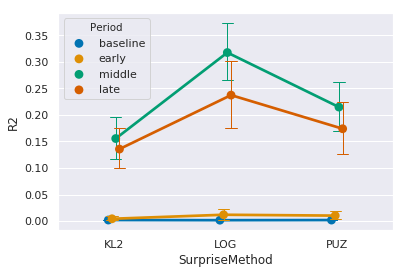

report for KL2

ANOVA SUMMARY

Source       SS    DF     MS        F    p-unc      np2
--------  -----  ----  -----  -------  -------  -------
Period    0.348     3  0.116   33.249    0.000    0.609
Within    0.223    64  0.003  nan      nan      nan


POST HOC TESTS

Contrast    A         B       Paired    Parametric         T     dof  Tail         p-unc        BF10    hedges
----------  --------  ------  --------  ------------  ------  ------  ---------  -------  ----------  --------
Period      baseline  early   False     True          -0.978  32.000  two-sided    0.336       0.475    -0.327
Period      baseline  middle  False     True          -7.634  32.000  two-sided    0.000  765600.000    -2.556
Period      baseline  late    False     True          -6.593  32.000  two-sided    0.000   52740.000    -2.208
Period      early     middle  False     True          -7.463  32.000  two-sided    0.000  495900.000    -2.499
Period      early     late    False     True          -6.431  32.

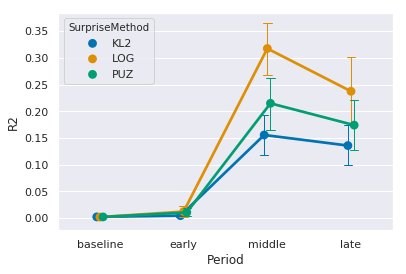

report for baseline

ANOVA SUMMARY

Source             SS    DF     MS        F    p-unc      np2
--------------  -----  ----  -----  -------  -------  -------
SurpriseMethod  0.000     2  0.000    0.761    0.473    0.031
Within          0.000    48  0.000  nan      nan      nan


POST HOC TESTS

Contrast        A    B    Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
--------------  ---  ---  --------  ------------  ------  ------  ---------  -------  ------  --------
SurpriseMethod  KL2  LOG  False     True           1.120  32.000  two-sided    0.271   0.533     0.375
SurpriseMethod  KL2  PUZ  False     True           0.271  32.000  two-sided    0.788   0.338     0.091
SurpriseMethod  LOG  PUZ  False     True          -0.891  32.000  two-sided    0.380   0.447    -0.298

report for early

ANOVA SUMMARY

Source             SS    DF     MS        F    p-unc      np2
--------------  -----  ----  -----  -------  -------  -------
SurpriseMethod  0.001     2  

In [20]:
A = []

for TaskNumber, learn_method, SurpriseMethod, Period in itertools.product([2], Learn_methods_list, SurpriseMethods_list, Periods_list):
    for sub, r2 in enumerate(decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'].max(axis=1)):
        A.append({
            'R2': r2,
            'Period': Period,
            'SurpriseMethod': SurpriseMethod,
            'TaskNumber': TaskNumber,
            'learn_method': learn_method,
            'Subject': sub
        })
    
df = pd.DataFrame(A)

sns.set()
sns.pointplot(data=df, x='SurpriseMethod', y='R2', hue='Period', dodge=True,
              capsize=.1, errwidth=1, palette='colorblind')
plt.show()

for SurpriseMethod in SurpriseMethods_list:
    print(f'report for {SurpriseMethod}')
    aov = pg.anova(data=df[df['SurpriseMethod'] == SurpriseMethod], dv='R2', between='Period', detailed=True)
    pg.print_table(aov)
    
    posthocs = pg.pairwise_ttests(dv='R2', between='Period',
                                  data=df[df['SurpriseMethod'] == SurpriseMethod])
    pg.print_table(posthocs)

    
sns.set()
sns.pointplot(data=df, x='Period', y='R2', hue='SurpriseMethod', dodge=True,
              capsize=.1, errwidth=1, palette='colorblind')
plt.show()

for Period in Periods_list:
    print(f'report for {Period}')
    aov = pg.anova(data=df[df['Period'] == Period], dv='R2', between='SurpriseMethod', detailed=True)
    pg.print_table(aov)
    
    posthocs = pg.pairwise_ttests(dv='R2', between='SurpriseMethod',
                                  data=df[df['Period'] == Period],)
    pg.print_table(posthocs)

